In [5]:
from bs4 import BeautifulSoup
import pandas as pd
import requests
import csv
import re
import numpy as np
import matplotlib as plt


In [6]:
session = requests.Session()
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/72.0.3626.109 Safari/537.36"
    }

house_urls_list = []
house_info = []

# 获取二手房每页url
def get_urls():
    #根据网页数设置范围
    for k in range(1,5):

        url = 'https://gz.lianjia.com/ershoufang/pg'+str(k)
        html = session.get(url, headers=headers)
        #根据网址获取网页
        soup = BeautifulSoup(html.text,'html.parser')
        ul  = soup.find("ul", { "class" : "sellListContent" })
        for li in ul :
            
            href = li.find("div", { "class" : "title" }).a.get('href')
            house_urls_list.append(href)   
    return house_urls_list
            
# 获取二手房数据
def house_data(house_url):
    html = session.get(house_url, headers=headers)
    soup = BeautifulSoup(html.text, 'html.parser')
    info ={}
    #获取小区信息
    arounInfo = soup.find('div',{'class':'aroundInfo'})
    info['小区名称'] = arounInfo.a.text
    info['区域'] = arounInfo.contents[1].a.text
    
    # 获取房屋价格
    t_price = soup.find('div',{"class" : 'price'})
    info['房屋总价'] = t_price.span.text + "万"
    s_price = soup.find('span',{"class" : 'unitPriceValue'})
    info['房屋单价'] = s_price.text
    
    # 获取房屋基本属性
    base = soup.find('div',{'class':'introContent'}).contents[1].ul.find_all('li')
    
    info['房屋户型'] = base[0].contents[1].string
    info['所在楼层'] = str(base[1].contents[1].string)
    info['建筑面积'] = base[2].contents[1].string
    info['户型结构'] = str(base[3].contents[1].string)
    info['建筑类型'] = str(base[5].contents[1].string)
    info['房屋朝向'] = str(base[6].contents[1].string)
    info['装修情况'] = str(base[7].contents[1].string)
    try:
        info['配备电梯'] = str(base[10].contents[1].string)
    except:
        info['配备电梯'] = None

    
    house_info.append(info)

house_urls = get_urls()
for i in range(len(house_urls)):    
    house_data(house_urls[i])
    #print( u'抓取第{}条信息'.format(i+1))

house_df = pd.DataFrame(house_info)
house_df.head()
# df.to_csv(r"F:\python\data\lianjia_guangzhou.csv", index=False, encoding='gb18030')

,区域,小区名称,建筑类型,建筑面积,户型结构,房屋单价,房屋总价,房屋户型,房屋朝向,所在楼层,装修情况,配备电梯
0,天河,南国嘉园,塔楼,71㎡,平层,44367元/平米,315万,2室1厅1厨1卫,北,低楼层 (共13层),钢混结构,有
1,海珠,天汇大厦,塔楼,76.8㎡,平层,37500元/平米,288万,2室1厅1厨1卫,南 北,中楼层 (共9层),钢混结构,无
2,增城,尚东阳光雅苑,板楼,67.15㎡,平层,20849元/平米,140万,2室2厅1厨1卫,东南,高楼层 (共4层),钢混结构,有
3,花都,富力金港城东区,塔楼,82.36㎡,平层,12871元/平米,106万,2室2厅1厨1卫,北,高楼层 (共18层),钢混结构,有
4,白云,广园中公安宿舍,塔楼,58.04㎡,平层,22399元/平米,130万,2室1厅1厨1卫,南 北,高楼层 (共9层),钢混结构,无


In [7]:
# # 查看缺失值情况
house_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 12 columns):
区域      120 non-null object
小区名称    120 non-null object
建筑类型    120 non-null object
建筑面积    120 non-null object
户型结构    120 non-null object
房屋单价    120 non-null object
房屋总价    120 non-null object
房屋户型    120 non-null object
房屋朝向    120 non-null object
所在楼层    120 non-null object
装修情况    120 non-null object
配备电梯    119 non-null object
dtypes: object(12)
memory usage: 11.3+ KB


In [8]:
# 看到上面的检查数据中有缺失值的存在
# 过滤缺失值
house_df.dropna(inplace=True)
house_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119 entries, 0 to 119
Data columns (total 12 columns):
区域      119 non-null object
小区名称    119 non-null object
建筑类型    119 non-null object
建筑面积    119 non-null object
户型结构    119 non-null object
房屋单价    119 non-null object
房屋总价    119 non-null object
房屋户型    119 non-null object
房屋朝向    119 non-null object
所在楼层    119 non-null object
装修情况    119 non-null object
配备电梯    119 non-null object
dtypes: object(12)
memory usage: 12.1+ KB


In [9]:
# 现在有些字段是带单位的字符串类型，将它们转换为不带单位的字符串类型。
house_df['房屋总价'] = house_df['房屋总价'].apply(lambda x: x.replace("万", "")).astype("float")
house_df['房屋单价'] = house_df['房屋单价'].apply(lambda x: x.replace("元/平米", "")).astype("float")
house_df['建筑面积'] = house_df['建筑面积'].apply(lambda x: x.replace("㎡", ""))
house_df['楼房楼层'] = house_df['所在楼层'].apply(lambda x:re.search('\d+', x).group()).astype("int")
house_df.head()

,区域,小区名称,建筑类型,建筑面积,户型结构,房屋单价,房屋总价,房屋户型,房屋朝向,所在楼层,装修情况,配备电梯,楼房楼层
0,天河,南国嘉园,塔楼,71,平层,44367.0,315.0,2室1厅1厨1卫,北,低楼层 (共13层),钢混结构,有,13
1,海珠,天汇大厦,塔楼,76.8,平层,37500.0,288.0,2室1厅1厨1卫,南 北,中楼层 (共9层),钢混结构,无,9
2,增城,尚东阳光雅苑,板楼,67.15,平层,20849.0,140.0,2室2厅1厨1卫,东南,高楼层 (共4层),钢混结构,有,4
3,花都,富力金港城东区,塔楼,82.36,平层,12871.0,106.0,2室2厅1厨1卫,北,高楼层 (共18层),钢混结构,有,18
4,白云,广园中公安宿舍,塔楼,58.04,平层,22399.0,130.0,2室1厅1厨1卫,南 北,高楼层 (共9层),钢混结构,无,9


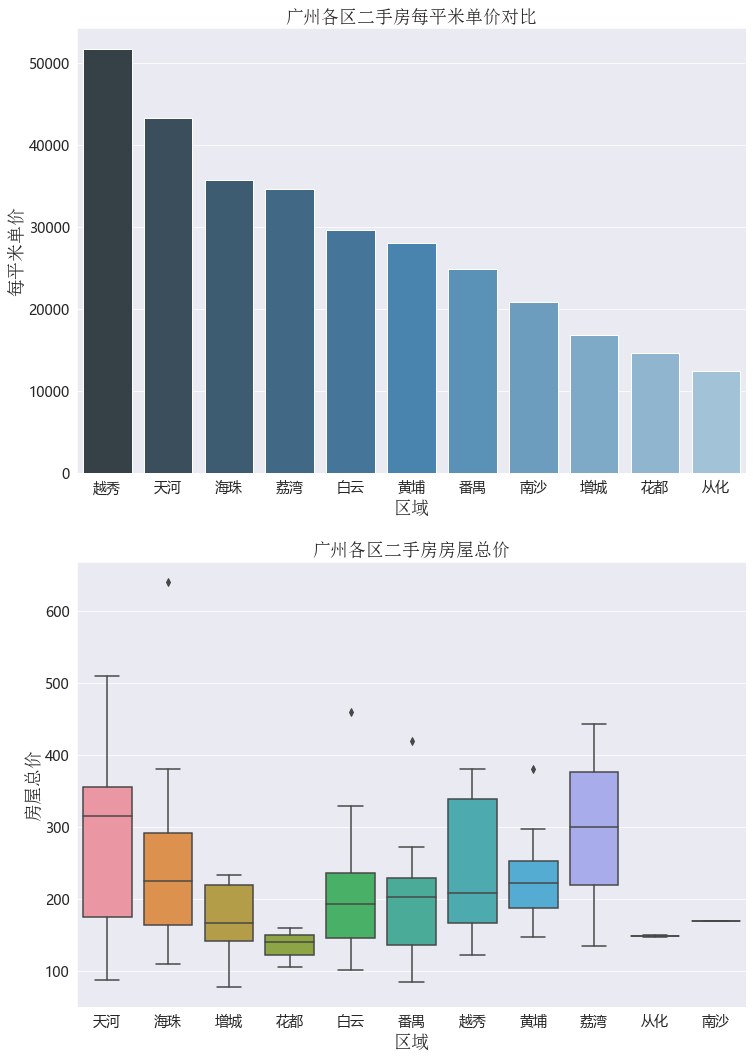

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.font_manager import FontProperties
font = FontProperties(fname=r"c:\windows\fonts\simsun.ttc",size=18)
sns.set_style("darkgrid",{"font.sans-serif":['microsoft yahei', 'KaiTi', 'Arial']})

# 按区域分析二手房价格
df_house_mean = house_df.groupby('区域')['房屋单价'].mean().sort_values(ascending=False).to_frame().reset_index()
f, [ax1, ax2] = plt.subplots(2, 1, figsize=(12, 18))

sns.barplot(x=u'区域', y=u'房屋单价', palette='Blues_d', data=df_house_mean, ax=ax1)
ax1.tick_params(labelsize=14)
ax1.set_title(u'广州各区二手房每平米单价对比',fontproperties=font)
ax1.set_xlabel(u'区域',fontproperties=font)
ax1.set_ylabel(u'每平米单价',fontproperties=font)

sns.boxplot(x=u'区域', y=u'房屋总价', data=house_df, ax=ax2)
ax2.tick_params(labelsize=14)
ax2.set_title(u'广州各区二手房房屋总价',fontproperties=font)
ax2.set_xlabel(u'区域',fontproperties=font)
ax2.set_ylabel(u'房屋总价',fontproperties=font)

plt.show()

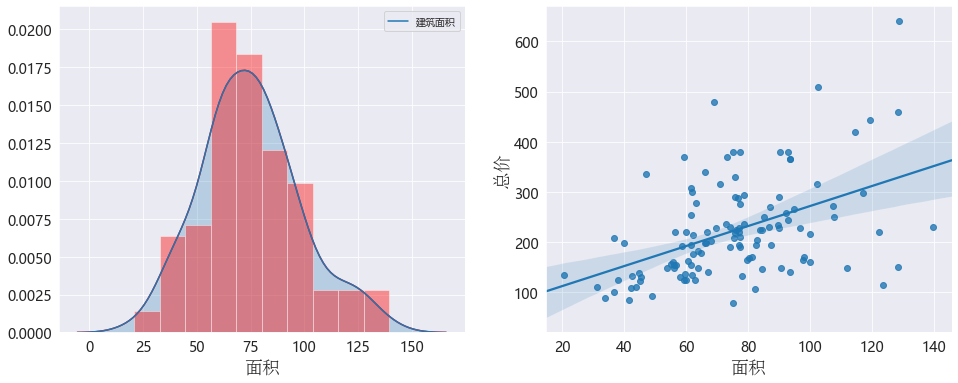

In [141]:
# 房屋面积分布情况，以及与价格的关系
f, [ax1,ax2] = plt.subplots(1, 2, figsize=(16, 6))
sns.set_style("darkgrid",{"font.sans-serif":['microsoft yahei', 'KaiTi', 'Arial']})
# 房屋面积分布
sns.distplot(house_df['建筑面积'], ax=ax1, color='r')
sns.kdeplot(house_df['建筑面积'], shade=True, ax=ax1)
ax1.set_xlabel('面积',fontproperties=font)
ax1.tick_params(labelsize=14)

# 房屋面积和价格的关系
sns.regplot(x='建筑面积', y='房屋总价', data=house_df, ax=ax2)
ax2.set_xlabel('面积',fontproperties=font)
ax2.set_ylabel('总价',fontproperties=font)
ax2.tick_params(labelsize=14)

plt.show()

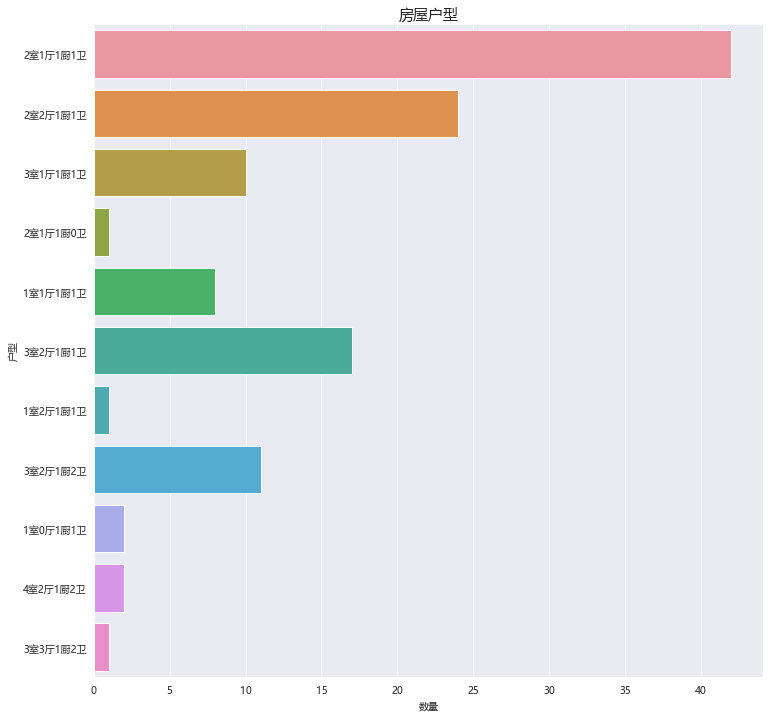

In [145]:
# 户型的数量情况
f, ax1 = plt.subplots(figsize=(12,12))
sns.countplot(y='房屋户型', data=house_df, ax=ax1)
ax1.set_title('房屋户型', fontsize=15)
ax1.set_xlabel('数量')
ax1.set_ylabel('户型')

plt.show()

In [146]:
# 电梯情况
house_df['配备电梯'].value_counts()

有    70
无    49
Name: 配备电梯, dtype: int64

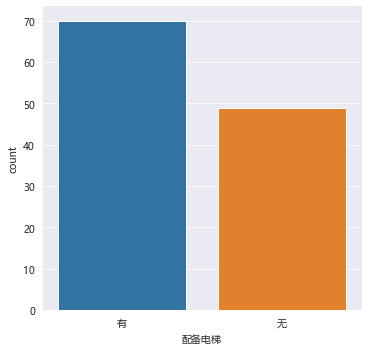

In [157]:
sns.catplot(x="配备电梯", kind="count", data=house_df);

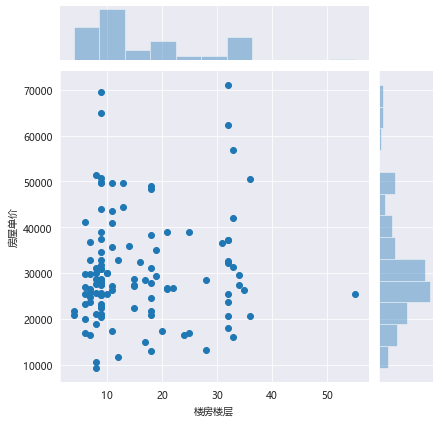

In [11]:
# 房屋楼层与价格
floor = house_df['楼房楼层']
sns.jointplot(x=floor, y="房屋单价", data=house_df);